In [1]:
from pathlib import Path
import pandas as pd
import geopandas as gp
from python_hll.hll import HLL
from python_hll.util import NumberUtil
from shapely.geometry import Point
import matplotlib.pyplot as plt
%matplotlib inline

OUTPUT = Path.cwd().parents[0] / "Output"
df = pd.read_csv(Path.cwd().parents[0] /"CSV"/"HLL"/"hashtag_latlng.csv",usecols = [0,1,2,3,4,5])
eu = gp.read_file(Path.cwd().parents[0]/ "Europe_coastline_shapefile" / "eu_shp_4326.shp",crs = 'epsg:4326')
df['post_hll'] = df['post_hll'].apply(lambda x: x[2:])
df['date_hll'] = df['date_hll'].apply(lambda x: x[2:])
df['user_hll'] = df['user_hll'].apply(lambda x: x[2:])
df

/home/sagnik/miniconda3/envs/workshop_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


,user_hll,post_hll,date_hll,latitude,longitude,hashtag
0,128b7fb4d8fa14cea9445b4a3eaa08e4f50475,128b7f81d7005ab2a56ed582a2d6fd191e353634077393...,128b7fcb2e51821af86f9a019032cc0076d0dc39c8c9d3...,28.017169,1.664273,afrique
1,128b7f9f066fa6767e1b74,128b7f1d27a3bfaaf36ec3,128b7fe6aa4fc35137c16a,28.017169,1.664273,alger
2,128b7fff8583ff68e4d52c,128b7fa09e9b1ed7ebcf78aad378f76965dcdc,128b7f9f2a0a9344c7fd84,28.017169,1.664273,algeria
3,128b7fff8583ff68e4d52c,128b7f3c1b3840c027340e,128b7f56d8c1622eb9ba87,28.017169,1.664273,algerian
4,128b7fff8583ff68e4d52c,128b7fa09e9b1ed7ebcf78aad378f76965dcdcdb15916a...,128b7f9f2a0a9344c7fd84,28.017169,1.664273,algerie
...,...,...,...,...,...,...
211547,128b7f118884db03390fed,128b7f03feddaf4ede1ac3,128b7f4b1278ad70c8792b,70.071230,19.437217,refugeeswelcome
211548,128b7fc0511d735a360ec4,128b7fc4a6567543b7ba85,128b7f4c59adaf6af1bdbc,70.266777,21.816807,asylchaos
211549,128b7f3f848baabe36a655,128b7f697b9c7e91df9fde,128b7f2cbcef3f1beacdc2,70.326849,30.646058,herecomesthesun
211550,128b7f3f848baabe36a655,128b7f697b9c7e91df9fde,128b7f2cbcef3f1beacdc2,70.326849,30.646058,migrants


In [2]:
#hll functions

def hll_from_byte(hll_set):
    """Return HLL set from binary representation"""
     
    return HLL.from_bytes(
        NumberUtil.from_hex(
            hll_set, 0, len(hll_set)))



def union_hll(hll, hll2):
    """Union of two HLL sets. The first HLL set will be modified in-place."""
    hll.union(hll2)
    
def union_all_hll(hll_series,cardinality = True):
    """HLL Union and (optional) cardinality estimation from series of hll sets

        Args:
        hll_series: Indexed series (bins) of hll sets. 
        cardinality: If True, returns cardinality (counts). Otherwise,
            the unioned hll set will be returned.
    """
    
    hll_set = None
    for hll_set_str in hll_series.values.tolist():
        if hll_set is None:
            # set first hll set
            hll_set = hll_from_byte(hll_set_str)
            continue
        hll_set2 = hll_from_byte(hll_set_str)
        union_hll(hll_set, hll_set2)
    return hll_set.cardinality()


In [21]:
#union,intersection plot functions

def extract_tags(htag,keep_column):
    
    column_list = ['post_hll','user_hll','date_hll']
    column_list.remove(f'{keep_column}')
    mask =f"hashtag == '{htag}'"
    df_htag = df.query(mask)
    df_htag.drop(columns = column_list,inplace =True)
    return df_htag

def three_df(tag_a,tag_b,tag_c,column):
    
    df_a = extract_tags(f'{tag_a}',f'{column}')
    df_b = extract_tags(f'{tag_b}',f'{column}')
    df_c = extract_tags(f'{tag_c}',f'{column}')     
    calculate_post_total(df_a,df_b,df_c)
    set_operations(df_a,df_b,df_c)

def calculate_post_total(df_a,df_b,df_c):
    
    dfs = {
           f"{TAG_A}" : df_a,
           f"{TAG_B}": df_b,
           f"{TAG_C}" :df_c
           }

    ptotal = {}
    for hashtag, dfs in dfs.items():
        # drop bins with no values
        cardinality_total = union_all_hll(
            dfs[f"{COLUMN}"].dropna())
        ptotal[hashtag] = cardinality_total
        print(
            f"{ptotal[hashtag]} distinct posts "
            f"used {hashtag.upper()}")   
    d_common(df_a,df_b,df_c,ptotal) 
    
   
    
def d_common(df_a,df_b,df_c,ptotal):
    
    union_a_b = pd.concat([df_a, df_b])
    union_a_c = pd.concat([df_a, df_c])
    union_b_c = pd.concat([df_c, df_b])


    dfs = {
        f"{TAG_A}_{TAG_C}": union_a_c,
        f"{TAG_A}_{TAG_B}": union_a_b,
        f"{TAG_B}_{TAG_C}": union_b_c
    }
    distinct_common = {}
    for hashtag_set, dfs in dfs.items():
        cardinality = union_all_hll(
            dfs[f"{COLUMN}"].dropna())
        distinct_common[hashtag_set] = cardinality
        print(
            f"{distinct_common[hashtag_set]} distinct total posts "
            f"which had either {hashtag_set.split('_')[0]} "
            f"or {hashtag_set.split('_')[1]} (union)")
        
    distinct_intersection = {}
    for a, b in [(f"{TAG_A}", f"{TAG_B}"), (f"{TAG_A}", f"{TAG_C}"), (f"{TAG_B}", f"{TAG_C}")]:
        a_total = ptotal[a]
        b_total = ptotal[b]
        common_tags = f'{a}_{b}'
        intersection_count = a_total + b_total - distinct_common[common_tags]
        distinct_intersection[common_tags] = intersection_count
        print(
            f"{distinct_intersection[common_tags]} distinct posts "
            f"with hashtags with {a} and {b} (intersection)")
     
    union_a_b_c = pd.concat([df_a, df_b, df_c])
    cardinality = union_all_hll(
        union_a_b_c[f"{COLUMN}"].dropna())
    union_count_all = cardinality    
    intersection_count_all = union_count_all - \
    ptotal[TAG_A] - \
    ptotal[TAG_B] - \
    ptotal[TAG_C] + \
    distinct_intersection[f'{TAG_A}_{TAG_B}'] + \
    distinct_intersection[f'{TAG_A}_{TAG_C}'] + \
    distinct_intersection[f'{TAG_B}_{TAG_C}']
    
    print(f'Union Count : {union_count_all}',
          f'Intersection Count : {intersection_count_all}')
    
def make_tuple(lat,lon):
    return (lat,lon)    

def make_lists(dfx):
    return dfx.apply(lambda x: make_tuple(x.latitude,x.longitude),axis=1).tolist()

def set_operations(df_a,df_b,df_c):
    set_a = set(make_lists(df_a))
    set_b = set(make_lists(df_b))
    set_c = set(make_lists(df_c))
    
    union_final = set_a.union(set_b,set_c)
    
    intersect_foo = set(set_a).intersection(set_b)
    intersect_final = set(set_c).intersection(intersect_foo)
    
    makeGeoSeries(union_final,intersect_final)

def makeGeoSeries(union, intersect):
    
    union_foo = [Point(coord[1], coord[0]) for coord in union]
    union_points = gp.GeoSeries(union_foo)
    union_points.set_crs(epsg =4326,inplace =True)
    
    intersect_foo = [Point(coord[1], coord[0]) for coord in intersect]
    intersect_points = gp.GeoSeries(intersect_foo)
    intersect_points.set_crs(epsg =4326,inplace =True)
    
    plot(union_points,intersect_points)
    
def plot(u_points,i_points):
    
    fig,(ax1,ax2) = plt.subplots(ncols =2,
                          nrows =1,
                          figsize=(10,12))
    for ax in [ax1,ax2]:
        eu.plot(ax = ax,
                facecolor = 'white',
                edgecolor = 'black'
               )
    u_points.plot(ax = ax1,
                  zorder= 5
                 )
    i_points.plot(ax = ax2,
                  zorder =5
                 )          
     
      

In [37]:
counts = df['hashtag'].value_counts().to_dict()
counts

{'refugees': 2943,
 'refugeeswelcome': 2719,
 'migrants': 2080,
 'migration': 2024,
 'immigration': 1832,
 'muslimban': 1783,
 'migranti': 1654,
 'refugee': 1139,
 'worldrefugeeday': 843,
 'trump': 769,
 'withrefugees': 756,
 'asylum': 749,
 'immigrazione': 731,
 'refugiados': 692,
 'brexit': 661,
 'refugeecrisis': 650,
 'immigrants': 647,
 'flüchtlinge': 644,
 'migrant': 628,
 'soteu': 563,
 'immigrati': 538,
 'lesbos': 515,
 'europe': 513,
 'humanrightsrefugee': 503,
 'syria': 480,
 'greece': 423,
 'welcomerefugees': 422,
 'merkel': 418,
 'réfugiés': 412,
 'calais': 407,
 'europa': 392,
 'immigrant': 390,
 'hostileenvironment': 381,
 'leavenoonebehind': 375,
 'migrantcrisis': 367,
 'moria': 352,
 'vluchtelingen': 348,
 'seebrücke': 341,
 'asyl': 329,
 'migranten': 328,
 'salvini': 326,
 'migrationeu': 319,
 'humanrights': 318,
 'calaisjungle': 311,
 'usa': 298,
 'integration': 297,
 'france': 287,
 'asilo': 275,
 'rifugiati': 273,
 'refugeeweek': 268,
 'syrianrefugees': 266,
 'asylum

/home/sagnik/miniconda3/envs/workshop_env/lib/python3.8/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
/home/sagnik/miniconda3/envs/workshop_env/lib/python3.8/site-packages/python_hll/util.py:342: RuntimeWarning: overflow encountered in long_scalars
  self._words[first_word_index] &= BitUtil.left_shift_long(1, bit_remainder) - 1


13347 distinct posts used REFUGEES
10007 distinct posts used REFUGEESWELCOME


/home/sagnik/miniconda3/envs/workshop_env/lib/python3.8/site-packages/python_hll/util.py:289: RuntimeWarning: overflow encountered in long_scalars
  self._words[first_word_index] &= BitUtil.left_shift_long(1, bit_remainder) - 1


9290 distinct posts used MIGRANTS
21934 distinct total posts which had either refugees or migrants (union)
22502 distinct total posts which had either refugees or refugeeswelcome (union)
19207 distinct total posts which had either refugeeswelcome or migrants (union)
852 distinct posts with hashtags with refugees and refugeeswelcome (intersection)
703 distinct posts with hashtags with refugees and migrants (intersection)
90 distinct posts with hashtags with refugeeswelcome and migrants (intersection)
Union Count : 31117 Intersection Count : 118
CPU times: user 58.5 s, sys: 456 ms, total: 59 s
Wall time: 58.4 s


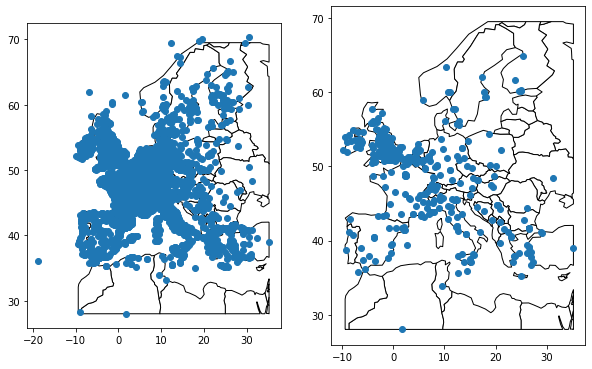

In [22]:
%%time

TAG_A ='refugees'
TAG_B = 'refugeeswelcome'
TAG_C = 'migrants'
COLUMN = "date_hll"

three_df(TAG_A,TAG_B,TAG_C,COLUMN)